In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import numpy as np
from scipy.stats import iqr
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# training parameters
epochs = 150
batch_size = 8
loss = tf.keras.losses.MeanAbsoluteError()
opt = tf.keras.optimizers.Adam()
input_path = '../../data/'
output_path = './model/'


In [3]:
# load data
x_train = pickle.load(open(input_path+'/x_train.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/y_train.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/sizes_train.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/x_test.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/y_test.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/sizes_test.pkl', 'rb'))


In [4]:
# standardize
x_train = [np.array(i) for i in x_train]
x_val = [np.array(i) for i in x_val]

y_train = [(i-j.mean())/j.std() for i,j in zip(y_train, x_train)]
y_val = [(i-j.mean())/j.std() for i,j in zip(y_val, x_val)]
x_train = [(i-i.mean())/i.std() for i in x_train]
x_val = [(i-i.mean())/i.std() for i in x_val]


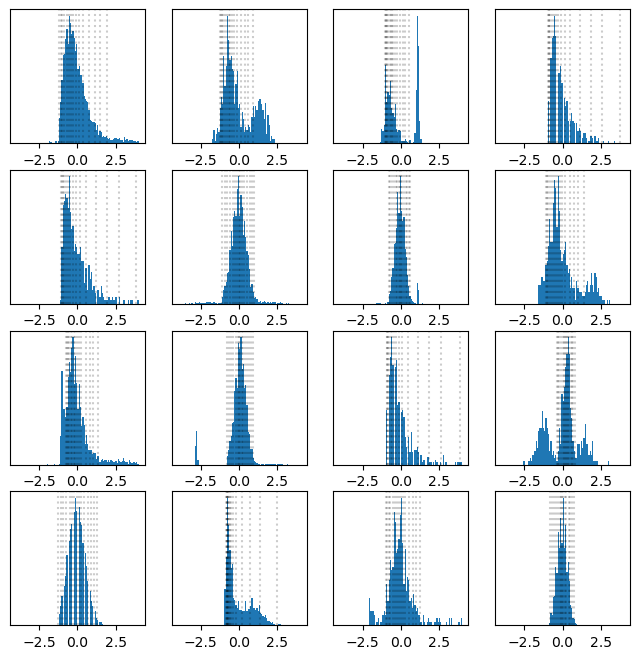

In [5]:
# plot example data points
nr = 4
nc = 4
plt.figure(figsize=(8,8))
idx = np.random.choice(len(x_train), nr*nc)
bins = np.linspace(-4, 4, 101)
for i in range(nr*nc):
    plt.subplot(nr, nc, i+1)
    plt.hist(x_train[idx[i]], bins, density=True)
    for j in range(len(y_train[0])):
        plt.axvline(y_train[idx[i]][j], c='k', linestyle=':', alpha=0.2)
    plt.yticks([])
    

In [6]:
# # optionally add size prediction

# y_train = np.array(y_train)
# y_train = np.hstack([
#     y_train, 
#     np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
# ])

# y_val = np.array(y_val)
# y_val = np.hstack([
#     y_val, 
#     np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
# ])

y_train = np.array(y_train)
y_val = np.array(y_val)


In [7]:
def extract_features(data):

    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features


In [8]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train)
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val)


In [9]:
x_train.shape

(5000, 100)

In [10]:
y_train.shape


(5000, 15)

In [11]:
# standardize

scalery = RobustScaler()
y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Model
import numpy as np

# Define model parameters
input_seq_length = 100  # Length of the input sequence (number of bins)
output_seq_length = 15  # Length of the output sequence (number of quantiles)
num_features_input = 1  # Single feature per time step in the input sequence
num_features_output = 1  # Single feature per time step in the output sequence
latent_dim = 64  # Latent dimensionality of the encoding space

# Define the encoder
encoder_inputs = Input(shape=(input_seq_length, num_features_input))
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = Input(shape=(output_seq_length, num_features_output))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_features_output)
decoder_outputs = TimeDistributed(decoder_dense)(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Summary of the model
model.summary()

# Prepare decoder input data
# Using zero vectors as the initial input for the decoder during training
decoder_input_data = np.zeros((len(x_train), output_seq_length, num_features_output))
decoder_input_data_val = np.zeros((len(x_val), output_seq_length, num_features_output))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 1)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 15, 1)]              0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 16896     ['input_1[0][0]']             
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                              

In [13]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    [x_train, decoder_input_data],
    y_train,
    validation_data = ([x_val, decoder_input_data_val], y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
    verbose = 2
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



Epoch 1/150


I0000 00:00:1716798364.322815   21764 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.57906, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.6034 - val_loss: 0.5791 - 11s/epoch - 18ms/step
Epoch 2/150

Epoch 2: val_loss improved from 0.57906 to 0.57171, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 9s - loss: 0.5893 - val_loss: 0.5717 - 9s/epoch - 14ms/step
Epoch 3/150

Epoch 3: val_loss improved from 0.57171 to 0.57011, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 10s - loss: 0.5848 - val_loss: 0.5701 - 10s/epoch - 16ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.57011 to 0.38283, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 10s - loss: 0.5241 - val_loss: 0.3828 - 10s/epoch - 16ms/step
Epoch 5/150

Epoch 5: val_loss improved from 0.38283 to 0.35996, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.3717 - val_loss: 0.3600 - 11s/epoch - 17ms/step
Epoch 6/150

Epoch 6: val_loss improved from 0.35996 to 0.30157, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 10s - loss: 0.3784 - val_loss: 0.3016 - 10s/epoch - 16ms/step
Epoch 7/150

Epoch 7: val_loss did not improve from 0.30157
625/625 - 6s - loss: 0.3067 - val_loss: 0.3534 - 6s/epoch - 9ms/step
Epoch 8/150

Epoch 8: val_loss improved from 0.30157 to 0.28098, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 10s - loss: 0.3080 - val_loss: 0.2810 - 10s/epoch - 16ms/step
Epoch 9/150

Epoch 9: val_loss did not improve from 0.28098
625/625 - 5s - loss: 0.5656 - val_loss: 0.5672 - 5s/epoch - 8ms/step
Epoch 10/150

Epoch 10: val_loss did not improve from 0.28098
625/625 - 5s - loss: 0.4893 - val_loss: 0.3110 - 5s/epoch - 8ms/step
Epoch 11/150

Epoch 11: val_loss did not improve from 0.28098
625/625 - 5s - loss: 0.2976 - val_loss: 0.2971 - 5s/epoch - 8ms/step
Epoch 12/150

Epoch 12: val_loss did not improve from 0.28098
625/625 - 6s - loss: 0.2791 - val_loss: 0.2862 - 6s/epoch - 9ms/step
Epoch 13/150

Epoch 13: val_loss did not improve from 0.28098
625/625 - 6s - loss: 0.2683 - val_loss: 0.2859 - 6s/epoch - 9ms/step
Epoch 14/150

Epoch 14: val_loss did not improve from 0.28098
625/625 - 5s - loss: 0.3000 - val_loss: 0.3387 - 5s/epoch - 9ms/step
Epoch 15/150

Epoch 15: val_loss improved from 0.28098 to 0.25940, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: .

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 10s - loss: 0.2740 - val_loss: 0.2594 - 10s/epoch - 17ms/step
Epoch 16/150

Epoch 16: val_loss did not improve from 0.25940
625/625 - 5s - loss: 0.2484 - val_loss: 0.2787 - 5s/epoch - 9ms/step
Epoch 17/150

Epoch 17: val_loss did not improve from 0.25940
625/625 - 5s - loss: 0.3378 - val_loss: 0.2848 - 5s/epoch - 9ms/step
Epoch 18/150

Epoch 18: val_loss did not improve from 0.25940
625/625 - 5s - loss: 0.2738 - val_loss: 0.2600 - 5s/epoch - 9ms/step
Epoch 19/150

Epoch 19: val_loss improved from 0.25940 to 0.23569, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.2501 - val_loss: 0.2357 - 11s/epoch - 18ms/step
Epoch 20/150

Epoch 20: val_loss did not improve from 0.23569
625/625 - 6s - loss: 0.2538 - val_loss: 0.2521 - 6s/epoch - 9ms/step
Epoch 21/150

Epoch 21: val_loss did not improve from 0.23569
625/625 - 6s - loss: 0.2497 - val_loss: 0.2816 - 6s/epoch - 9ms/step
Epoch 22/150

Epoch 22: val_loss did not improve from 0.23569
625/625 - 6s - loss: 0.2583 - val_loss: 0.2414 - 6s/epoch - 9ms/step
Epoch 23/150

Epoch 23: val_loss did not improve from 0.23569
625/625 - 6s - loss: 0.4402 - val_loss: 0.5581 - 6s/epoch - 9ms/step
Epoch 24/150

Epoch 24: val_loss did not improve from 0.23569
625/625 - 6s - loss: 0.5744 - val_loss: 0.5787 - 6s/epoch - 9ms/step
Epoch 25/150

Epoch 25: val_loss did not improve from 0.23569
625/625 - 6s - loss: 0.5839 - val_loss: 0.5806 - 6s/epoch - 9ms/step
Epoch 26/150

Epoch 26: val_loss did not improve from 0.23569
625/625 - 6s - loss: 0.5019 - val_loss: 0.4301 - 6s/epoch - 9ms/step
Epoch 27/15

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.2663 - val_loss: 0.2346 - 11s/epoch - 17ms/step
Epoch 40/150

Epoch 40: val_loss did not improve from 0.23457
625/625 - 6s - loss: 0.2558 - val_loss: 0.2457 - 6s/epoch - 9ms/step
Epoch 41/150

Epoch 41: val_loss did not improve from 0.23457
625/625 - 6s - loss: 0.2677 - val_loss: 0.2702 - 6s/epoch - 9ms/step
Epoch 42/150

Epoch 42: val_loss improved from 0.23457 to 0.21910, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.2468 - val_loss: 0.2191 - 11s/epoch - 17ms/step
Epoch 43/150

Epoch 43: val_loss did not improve from 0.21910
625/625 - 6s - loss: 0.2405 - val_loss: 0.2433 - 6s/epoch - 9ms/step
Epoch 44/150

Epoch 44: val_loss did not improve from 0.21910
625/625 - 6s - loss: 0.2565 - val_loss: 0.3178 - 6s/epoch - 9ms/step
Epoch 45/150

Epoch 45: val_loss improved from 0.21910 to 0.21740, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.2474 - val_loss: 0.2174 - 11s/epoch - 18ms/step
Epoch 46/150

Epoch 46: val_loss improved from 0.21740 to 0.20840, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 10s - loss: 0.2188 - val_loss: 0.2084 - 10s/epoch - 17ms/step
Epoch 47/150

Epoch 47: val_loss did not improve from 0.20840
625/625 - 6s - loss: 0.2589 - val_loss: 0.2255 - 6s/epoch - 9ms/step
Epoch 48/150

Epoch 48: val_loss did not improve from 0.20840
625/625 - 6s - loss: 0.2174 - val_loss: 0.2441 - 6s/epoch - 9ms/step
Epoch 49/150

Epoch 49: val_loss did not improve from 0.20840
625/625 - 6s - loss: 0.2288 - val_loss: 0.2566 - 6s/epoch - 9ms/step
Epoch 50/150

Epoch 50: val_loss improved from 0.20840 to 0.20572, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.2131 - val_loss: 0.2057 - 11s/epoch - 17ms/step
Epoch 51/150

Epoch 51: val_loss did not improve from 0.20572
625/625 - 6s - loss: 0.2349 - val_loss: 0.2136 - 6s/epoch - 9ms/step
Epoch 52/150

Epoch 52: val_loss improved from 0.20572 to 0.20055, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.2105 - val_loss: 0.2006 - 11s/epoch - 17ms/step
Epoch 53/150

Epoch 53: val_loss did not improve from 0.20055
625/625 - 6s - loss: 0.2250 - val_loss: 0.6136 - 6s/epoch - 9ms/step
Epoch 54/150

Epoch 54: val_loss improved from 0.20055 to 0.19133, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 10s - loss: 0.2137 - val_loss: 0.1913 - 10s/epoch - 16ms/step
Epoch 55/150

Epoch 55: val_loss improved from 0.19133 to 0.18275, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.1903 - val_loss: 0.1828 - 11s/epoch - 17ms/step
Epoch 56/150

Epoch 56: val_loss did not improve from 0.18275
625/625 - 6s - loss: 0.2196 - val_loss: 0.2726 - 6s/epoch - 9ms/step
Epoch 57/150

Epoch 57: val_loss did not improve from 0.18275
625/625 - 5s - loss: 0.2017 - val_loss: 0.1934 - 5s/epoch - 8ms/step
Epoch 58/150

Epoch 58: val_loss did not improve from 0.18275
625/625 - 4s - loss: 0.2833 - val_loss: 0.2171 - 4s/epoch - 7ms/step
Epoch 59/150

Epoch 59: val_loss did not improve from 0.18275
625/625 - 4s - loss: 0.1900 - val_loss: 0.1846 - 4s/epoch - 7ms/step
Epoch 60/150

Epoch 60: val_loss did not improve from 0.18275
625/625 - 5s - loss: 0.1902 - val_loss: 0.2105 - 5s/epoch - 7ms/step
Epoch 61/150

Epoch 61: val_loss did not improve from 0.18275
625/625 - 4s - loss: 0.2457 - val_loss: 0.1955 - 4s/epoch - 7ms/step
Epoch 62/150

Epoch 62: val_loss did not improve from 0.18275
625/625 - 4s - loss: 0.1880 - val_loss: 0.2289 - 4s/epoch - 7ms/step
Epoch 63/15

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 8s - loss: 0.2128 - val_loss: 0.1796 - 8s/epoch - 13ms/step
Epoch 64/150

Epoch 64: val_loss did not improve from 0.17961
625/625 - 5s - loss: 0.1788 - val_loss: 0.2267 - 5s/epoch - 7ms/step
Epoch 65/150

Epoch 65: val_loss improved from 0.17961 to 0.17126, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 9s - loss: 0.1814 - val_loss: 0.1713 - 9s/epoch - 14ms/step
Epoch 66/150

Epoch 66: val_loss improved from 0.17126 to 0.16094, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 9s - loss: 0.1808 - val_loss: 0.1609 - 9s/epoch - 15ms/step
Epoch 67/150

Epoch 67: val_loss did not improve from 0.16094
625/625 - 5s - loss: 0.1710 - val_loss: 0.1677 - 5s/epoch - 8ms/step
Epoch 68/150

Epoch 68: val_loss did not improve from 0.16094
625/625 - 5s - loss: 0.1773 - val_loss: 0.1711 - 5s/epoch - 8ms/step
Epoch 69/150

Epoch 69: val_loss did not improve from 0.16094
625/625 - 5s - loss: 0.1724 - val_loss: 0.1627 - 5s/epoch - 7ms/step
Epoch 70/150

Epoch 70: val_loss did not improve from 0.16094
625/625 - 4s - loss: 0.1782 - val_loss: 0.1892 - 4s/epoch - 7ms/step
Epoch 71/150

Epoch 71: val_loss improved from 0.16094 to 0.15912, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 9s - loss: 0.1634 - val_loss: 0.1591 - 9s/epoch - 14ms/step
Epoch 72/150

Epoch 72: val_loss did not improve from 0.15912
625/625 - 4s - loss: 0.1840 - val_loss: 0.1777 - 4s/epoch - 7ms/step
Epoch 73/150

Epoch 73: val_loss did not improve from 0.15912
625/625 - 4s - loss: 0.1728 - val_loss: 0.1674 - 4s/epoch - 7ms/step
Epoch 74/150

Epoch 74: val_loss did not improve from 0.15912
625/625 - 5s - loss: 0.1662 - val_loss: 0.1640 - 5s/epoch - 7ms/step
Epoch 75/150

Epoch 75: val_loss improved from 0.15912 to 0.15023, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 8s - loss: 0.1546 - val_loss: 0.1502 - 8s/epoch - 13ms/step
Epoch 76/150

Epoch 76: val_loss did not improve from 0.15023
625/625 - 4s - loss: 0.2020 - val_loss: 0.1580 - 4s/epoch - 7ms/step
Epoch 77/150

Epoch 77: val_loss did not improve from 0.15023
625/625 - 4s - loss: 0.1528 - val_loss: 0.1556 - 4s/epoch - 7ms/step
Epoch 78/150

Epoch 78: val_loss did not improve from 0.15023
625/625 - 4s - loss: 0.1580 - val_loss: 0.1567 - 4s/epoch - 7ms/step
Epoch 79/150

Epoch 79: val_loss did not improve from 0.15023
625/625 - 4s - loss: 0.2109 - val_loss: 0.1549 - 4s/epoch - 7ms/step
Epoch 80/150

Epoch 80: val_loss did not improve from 0.15023
625/625 - 5s - loss: 0.1612 - val_loss: 0.1563 - 5s/epoch - 7ms/step
Epoch 81/150

Epoch 81: val_loss improved from 0.15023 to 0.14604, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 8s - loss: 0.1582 - val_loss: 0.1460 - 8s/epoch - 13ms/step
Epoch 82/150

Epoch 82: val_loss did not improve from 0.14604
625/625 - 5s - loss: 0.1487 - val_loss: 0.1564 - 5s/epoch - 8ms/step
Epoch 83/150

Epoch 83: val_loss did not improve from 0.14604
625/625 - 6s - loss: 0.1458 - val_loss: 0.1501 - 6s/epoch - 9ms/step
Epoch 84/150

Epoch 84: val_loss did not improve from 0.14604
625/625 - 5s - loss: 0.1435 - val_loss: 0.1506 - 5s/epoch - 9ms/step
Epoch 85/150

Epoch 85: val_loss did not improve from 0.14604
625/625 - 5s - loss: 0.1420 - val_loss: 0.1620 - 5s/epoch - 9ms/step
Epoch 86/150

Epoch 86: val_loss did not improve from 0.14604
625/625 - 6s - loss: 0.1465 - val_loss: 0.1593 - 6s/epoch - 9ms/step
Epoch 87/150

Epoch 87: val_loss did not improve from 0.14604
625/625 - 6s - loss: 0.1470 - val_loss: 0.1495 - 6s/epoch - 9ms/step
Epoch 88/150

Epoch 88: val_loss did not improve from 0.14604
625/625 - 6s - loss: 0.1566 - val_loss: 0.1525 - 6s/epoch - 9ms/step
Epoch 89/150


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.1440 - val_loss: 0.1415 - 11s/epoch - 17ms/step
Epoch 90/150

Epoch 90: val_loss improved from 0.14149 to 0.13527, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.1382 - val_loss: 0.1353 - 11s/epoch - 17ms/step
Epoch 91/150

Epoch 91: val_loss did not improve from 0.13527
625/625 - 6s - loss: 0.1418 - val_loss: 0.1555 - 6s/epoch - 9ms/step
Epoch 92/150

Epoch 92: val_loss did not improve from 0.13527
625/625 - 6s - loss: 0.1367 - val_loss: 0.1438 - 6s/epoch - 9ms/step
Epoch 93/150

Epoch 93: val_loss did not improve from 0.13527
625/625 - 6s - loss: 0.1353 - val_loss: 0.1482 - 6s/epoch - 9ms/step
Epoch 94/150

Epoch 94: val_loss did not improve from 0.13527
625/625 - 6s - loss: 0.2070 - val_loss: 0.1482 - 6s/epoch - 9ms/step
Epoch 95/150

Epoch 95: val_loss did not improve from 0.13527
625/625 - 6s - loss: 0.1641 - val_loss: 0.1447 - 6s/epoch - 9ms/step
Epoch 96/150

Epoch 96: val_loss did not improve from 0.13527
625/625 - 6s - loss: 0.1361 - val_loss: 0.2118 - 6s/epoch - 10ms/step
Epoch 97/150

Epoch 97: val_loss did not improve from 0.13527
625/625 - 6s - loss: 0.1429 - val_loss: 0.1383 - 6s/epoch - 9ms/step
Epoch 98/1

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.1287 - val_loss: 0.1341 - 11s/epoch - 18ms/step
Epoch 104/150

Epoch 104: val_loss did not improve from 0.13405
625/625 - 6s - loss: 0.1540 - val_loss: 0.1558 - 6s/epoch - 9ms/step
Epoch 105/150

Epoch 105: val_loss did not improve from 0.13405
625/625 - 6s - loss: 0.1347 - val_loss: 0.1382 - 6s/epoch - 9ms/step
Epoch 106/150

Epoch 106: val_loss did not improve from 0.13405
625/625 - 6s - loss: 0.1495 - val_loss: 0.1406 - 6s/epoch - 9ms/step
Epoch 107/150

Epoch 107: val_loss did not improve from 0.13405
625/625 - 6s - loss: 0.1474 - val_loss: 0.1520 - 6s/epoch - 9ms/step
Epoch 108/150

Epoch 108: val_loss did not improve from 0.13405
625/625 - 6s - loss: 0.1404 - val_loss: 0.2167 - 6s/epoch - 9ms/step
Epoch 109/150

Epoch 109: val_loss did not improve from 0.13405
625/625 - 6s - loss: 0.1708 - val_loss: 0.1384 - 6s/epoch - 9ms/step
Epoch 110/150

Epoch 110: val_loss did not improve from 0.13405
625/625 - 6s - loss: 0.1768 - val_loss: 0.1719 - 6s/epoch - 9ms/st

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.1352 - val_loss: 0.1317 - 11s/epoch - 17ms/step
Epoch 112/150

Epoch 112: val_loss did not improve from 0.13172
625/625 - 6s - loss: 0.1237 - val_loss: 0.1327 - 6s/epoch - 9ms/step
Epoch 113/150

Epoch 113: val_loss improved from 0.13172 to 0.13122, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 10s - loss: 0.1243 - val_loss: 0.1312 - 10s/epoch - 17ms/step
Epoch 114/150

Epoch 114: val_loss did not improve from 0.13122
625/625 - 6s - loss: 0.1252 - val_loss: 0.1524 - 6s/epoch - 9ms/step
Epoch 115/150

Epoch 115: val_loss improved from 0.13122 to 0.12962, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 11s - loss: 0.1252 - val_loss: 0.1296 - 11s/epoch - 17ms/step
Epoch 116/150

Epoch 116: val_loss did not improve from 0.12962
625/625 - 6s - loss: 0.1265 - val_loss: 0.1434 - 6s/epoch - 9ms/step
Epoch 117/150

Epoch 117: val_loss did not improve from 0.12962
625/625 - 6s - loss: 0.1261 - val_loss: 0.1375 - 6s/epoch - 9ms/step
Epoch 118/150

Epoch 118: val_loss did not improve from 0.12962
625/625 - 6s - loss: 0.1319 - val_loss: 0.1440 - 6s/epoch - 9ms/step
Epoch 119/150

Epoch 119: val_loss did not improve from 0.12962
625/625 - 6s - loss: 0.1253 - val_loss: 0.1419 - 6s/epoch - 9ms/step
Epoch 120/150

Epoch 120: val_loss did not improve from 0.12962
625/625 - 6s - loss: 0.1216 - val_loss: 0.1415 - 6s/epoch - 9ms/step
Epoch 121/150

Epoch 121: val_loss did not improve from 0.12962
625/625 - 6s - loss: 0.1240 - val_loss: 0.1301 - 6s/epoch - 9ms/step
Epoch 122/150

Epoch 122: val_loss did not improve from 0.12962
625/625 - 6s - loss: 0.1228 - val_loss: 0.1404 - 6s/epoch - 9ms/st

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 8s - loss: 0.1215 - val_loss: 0.1287 - 8s/epoch - 13ms/step
Epoch 131/150

Epoch 131: val_loss improved from 0.12871 to 0.12797, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 8s - loss: 0.1194 - val_loss: 0.1280 - 8s/epoch - 13ms/step
Epoch 132/150

Epoch 132: val_loss did not improve from 0.12797
625/625 - 5s - loss: 0.1217 - val_loss: 0.1353 - 5s/epoch - 8ms/step
Epoch 133/150

Epoch 133: val_loss did not improve from 0.12797
625/625 - 5s - loss: 0.1175 - val_loss: 0.1320 - 5s/epoch - 8ms/step
Epoch 134/150

Epoch 134: val_loss improved from 0.12797 to 0.12697, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 9s - loss: 0.1169 - val_loss: 0.1270 - 9s/epoch - 14ms/step
Epoch 135/150

Epoch 135: val_loss did not improve from 0.12697
625/625 - 5s - loss: 0.1281 - val_loss: 0.1330 - 5s/epoch - 9ms/step
Epoch 136/150

Epoch 136: val_loss did not improve from 0.12697
625/625 - 5s - loss: 0.1298 - val_loss: 0.1311 - 5s/epoch - 8ms/step
Epoch 137/150

Epoch 137: val_loss did not improve from 0.12697
625/625 - 5s - loss: 0.1232 - val_loss: 0.1334 - 5s/epoch - 7ms/step
Epoch 138/150

Epoch 138: val_loss did not improve from 0.12697
625/625 - 5s - loss: 0.1144 - val_loss: 0.1284 - 5s/epoch - 8ms/step
Epoch 139/150

Epoch 139: val_loss did not improve from 0.12697
625/625 - 5s - loss: 0.1123 - val_loss: 0.1309 - 5s/epoch - 7ms/step
Epoch 140/150

Epoch 140: val_loss did not improve from 0.12697
625/625 - 5s - loss: 0.1162 - val_loss: 0.1367 - 5s/epoch - 8ms/step
Epoch 141/150

Epoch 141: val_loss did not improve from 0.12697
625/625 - 5s - loss: 0.1252 - val_loss: 0.1325 - 5s/epoch - 7ms/step

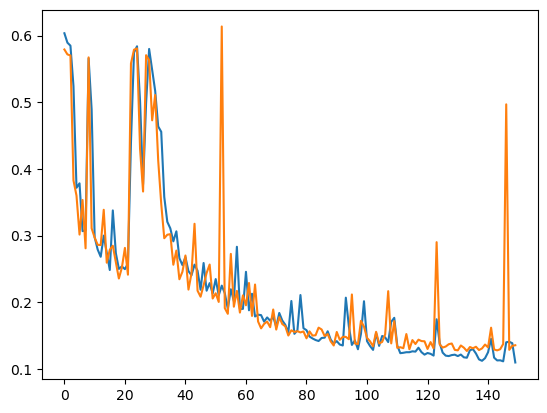

In [14]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);


In [15]:
# save scalers

with open(output_path+'/model_y_scaler.pkl', 'wb') as f:
    pickle.dump(scalery, f)
